# Fragility Analyses With Row/Column Perturbations

Since the linear operator estimated from the windowed data matrices are not symmetric, then the corresponding row and column perturbations are different. Although there lacks some theory to describe how different they are depending on matrix properties, we can empirically investigate the differences in the context of EZ localization.

Here, we:

1. load and visualize the column/row perturbed fragility heaatmaps
2. load and visualize their combinations (mean, ratio)

In [119]:
import numpy as np
import pandas as pd
import mne
import os
import json
import os.path as op
from pathlib import Path
import collections
from pprint import pprint
from natsort import natsorted

from sklearn.datasets import make_spd_matrix
from mne.io import RawArray
from mne import create_info
from mne_bids import BIDSPath, get_entity_vals, read_raw_bids
import mne
mne.utils.use_log_level('error')
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl

import pingouin as pg
import dabest

from eztrack.io.base import _add_desc_to_bids_fname, concatenate_derivs
from eztrack.io import read_derivative_npy, DerivativeArray, create_deriv_info
from eztrack.fragility import (lds_raw_fragility, DiscreteLinearSystem, 
                               SystemIDModel, StructuredPerturbationModel)
from eztrack.viz import _load_turbo, generate_heatmap
from eztrack.posthoc.hypo import compute_null

_load_turbo()

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
def get_resected_chs(subject, root):
    bids_path = BIDSPath(subject=subject, root=root,
                         suffix='channels', extension='.tsv')
    ch_fpaths = bids_path.match()

    # read in sidecar channels.tsv
    channels_pd = pd.read_csv(ch_fpaths[0], sep='\t')
    description_chs = pd.Series(channels_pd.description.values, index=channels_pd.name).to_dict()
    resected_chs = [ch for ch, description in description_chs.items() if description == 'resected']
    return resected_chs

# Configure Paths and BIDS related metadata

In [3]:
# load in originally ran npy data
root = Path('/Users/adam2392/OneDrive - Johns Hopkins/sickkids/')
# root = Path('/Users/adam2392/Dropbox/epilepsy_bids/')
deriv_root = root / 'derivatives'
reference = 'monopolar'
sampling_res = '1000Hz'  # 'originalsampling'
deriv_chain = Path(sampling_res) / 'radius1.25' / 'fragility' / reference
deriv_path = deriv_root / deriv_chain

figures_path = deriv_root / 'figures'

sessions = ['extraoperative', 'preresection', 
            'intraresection', 'postresection']
desc = 'perturbmatrix'
rowdesc = 'rowperturbmatrix'

In [4]:
subject = 'E1'
session = 'extraoperative'
task = 'ictal'
acquisition = 'ecog'
run = '01'
datatype = 'ieeg'
extension = '.json'

# subject = 'pt1'
# session = 'presurgery'
# acquisition = 'ecog'
# run = '01'

In [255]:
subjects = get_entity_vals(deriv_path, 'subject')
ignore_subjects = [sub for sub in subjects if sub != subject]

sessions = get_entity_vals(deriv_path, 'session', ignore_subjects=ignore_subjects)
ignore_sessions = [ses for ses in sessions if ses != session]

tasks = get_entity_vals(deriv_path, 'task', 
                        ignore_subjects=ignore_subjects,
                        ignore_sessions=ignore_sessions
                       )

print(f'These are the tasks for {subject} {session}: {tasks}')
task = tasks[-1]

print(task)

These are the tasks for E1 extraoperative: ['ictal', 'interictalasleep', 'interictalawake']
interictalawake


In [256]:
bids_path = BIDSPath(subject=subject, session=session,task=task,
                    acquisition=acquisition, run=run, suffix=datatype,
                    datatype=datatype, extension=extension,
                    root=root)
print(bids_path)

/Users/adam2392/OneDrive - Johns Hopkins/sickkids/sub-E1/ses-extraoperative/ieeg/sub-E1_ses-extraoperative_task-interictalawake_acq-ecog_run-01_ieeg.json


In [257]:
deriv_fname = _add_desc_to_bids_fname(bids_path.basename, description=desc)
print(deriv_fname)

sub-E1_ses-extraoperative_task-interictalawake_acq-ecog_run-01_desc-perturbmatrix_ieeg.json


In [258]:
deriv_fpath = deriv_root / deriv_chain / f'sub-{subject}' / deriv_fname
print(deriv_fpath)
print(deriv_fpath.exists())

/Users/adam2392/OneDrive - Johns Hopkins/sickkids/derivatives/1000Hz/radius1.25/fragility/monopolar/sub-E1/sub-E1_ses-extraoperative_task-interictalawake_acq-ecog_run-01_desc-perturbmatrix_ieeg.json
True


# Load Derivative Data

In [259]:
deriv = read_derivative_npy(deriv_fpath, preload=True, verbose=False)

print(deriv)

<DerivativeNumpy | sub-E1_ses-extraoperative_task-interictalawake_acq-ecog_run-01_desc-perturbmatrix_ieeg.npy, shape: (98, 1205) (98 chs x 1205 times) (301.0 s), ~1.1 MB, data loaded | reference=monopolar | perturbmatrix>


## First look at column perturbations

In [260]:
deriv.plot_heatmap(cmap='turbo')

(<Figure size 1800x1800 with 2 Axes>, <AxesSubplot:xlabel='Time (Secs)'>)

Error in callback <function flush_figures at 0x13128a3a0> (for post_execute):


KeyboardInterrupt: 

<DerivativeNumpy | sub-E1_ses-extraoperative_task-interictalawake_acq-ecog_run-01_desc-perturbmatrix_ieeg.npy, shape: (98, 1205) (98 chs x 1205 times) (301.0 s), ~1.1 MB, data loaded | reference=monopolar | perturbmatrix>


(<Figure size 1800x1800 with 2 Axes>, <AxesSubplot:xlabel='Time (Secs)'>)

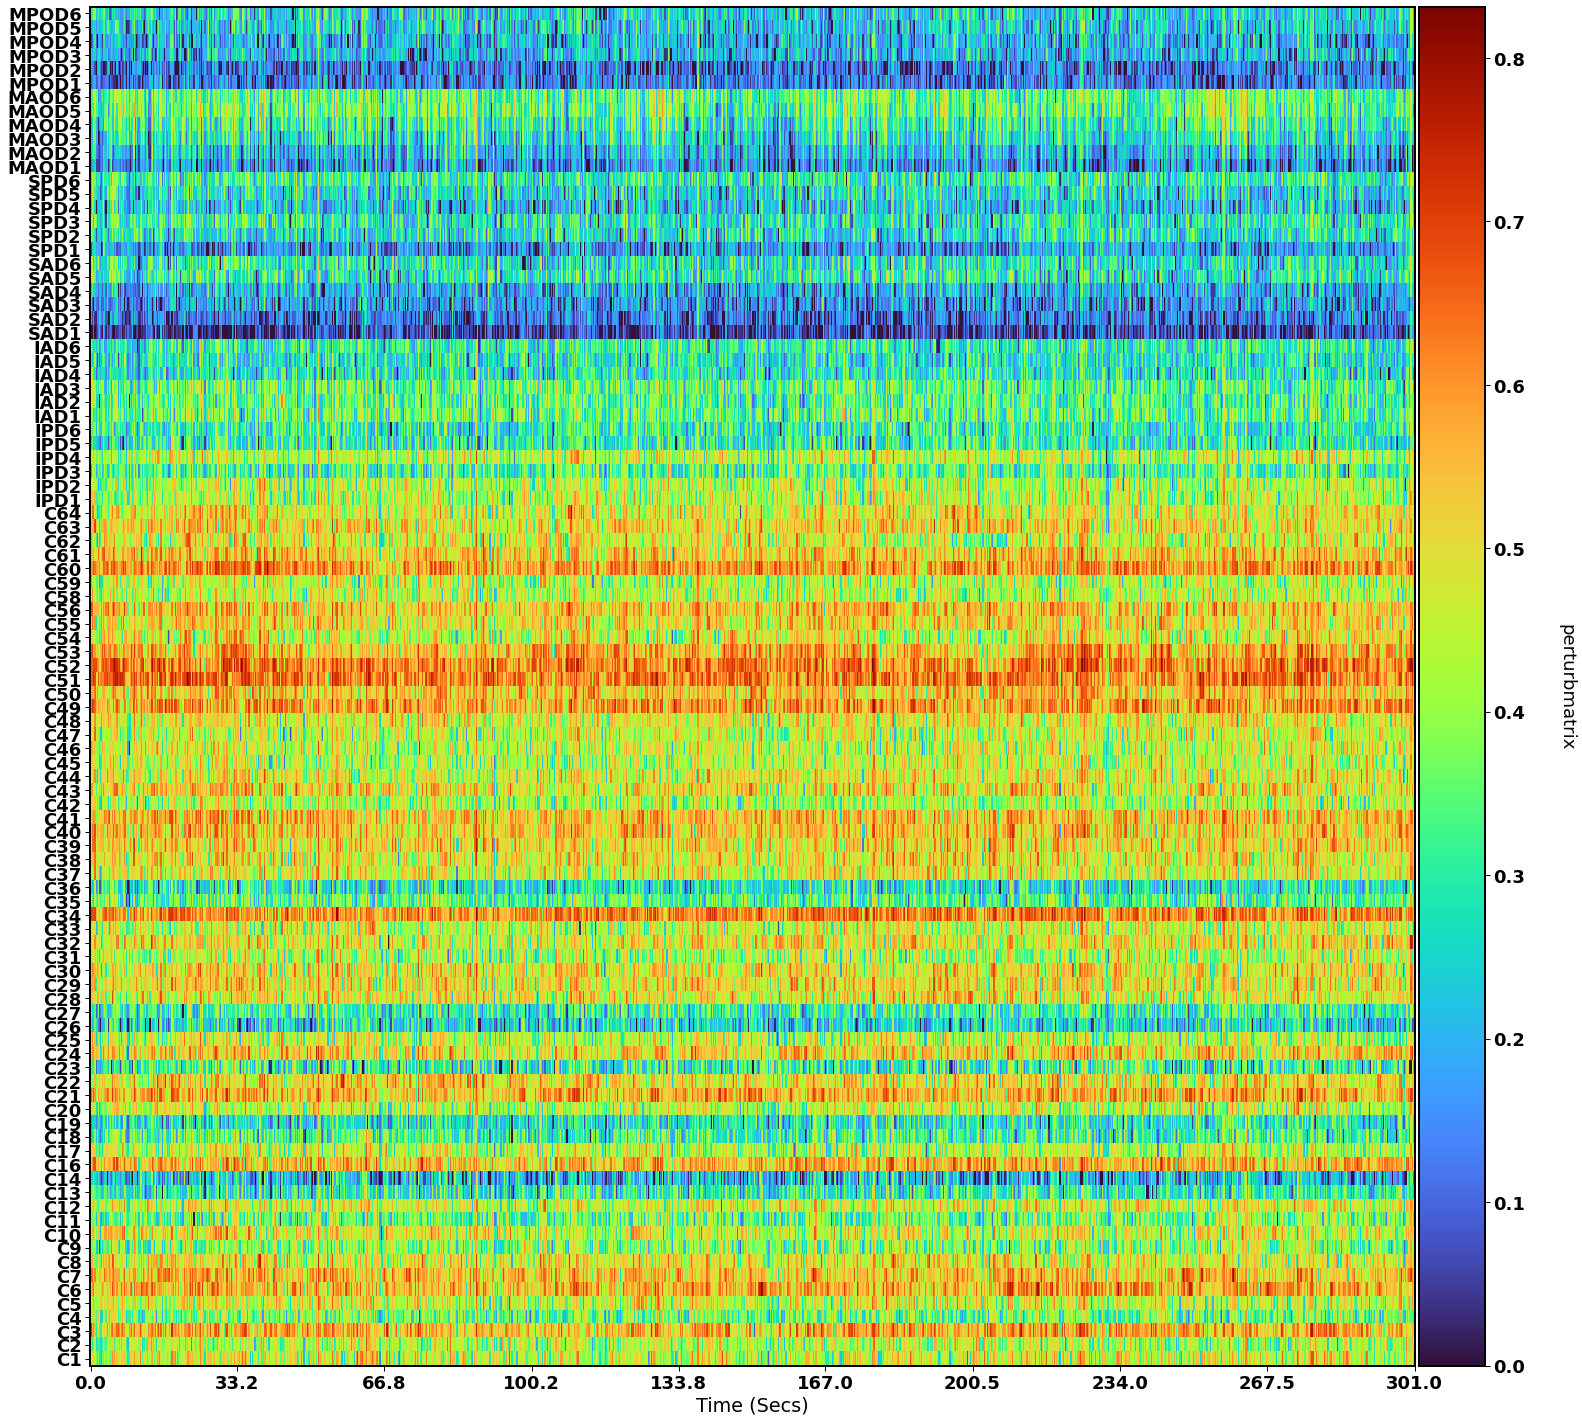

In [261]:
# visualize data
deriv_copy = deriv.copy()
deriv_copy.normalize()
deriv_copy.plot_heatmap(cmap='turbo')

## Next look at row perturbations

In [262]:
rowderiv_fpath = str(deriv_fpath).replace(desc, rowdesc)
print(rowderiv_fpath)

/Users/adam2392/OneDrive - Johns Hopkins/sickkids/derivatives/1000Hz/radius1.25/fragility/monopolar/sub-E1/sub-E1_ses-extraoperative_task-interictalawake_acq-ecog_run-01_desc-rowperturbmatrix_ieeg.json


In [263]:
rowderiv = read_derivative_npy(rowderiv_fpath, preload=True, verbose=False)

print(rowderiv)

<DerivativeNumpy | sub-E1_ses-extraoperative_task-interictalawake_acq-ecog_run-01_desc-rowperturbmatrix_ieeg.npy, shape: (98, 1205) (98 chs x 1205 times) (301.0 s), ~1.1 MB, data loaded | reference=monopolar | rowperturbmatrix>


(<Figure size 1800x1800 with 2 Axes>, <AxesSubplot:xlabel='Time (Secs)'>)

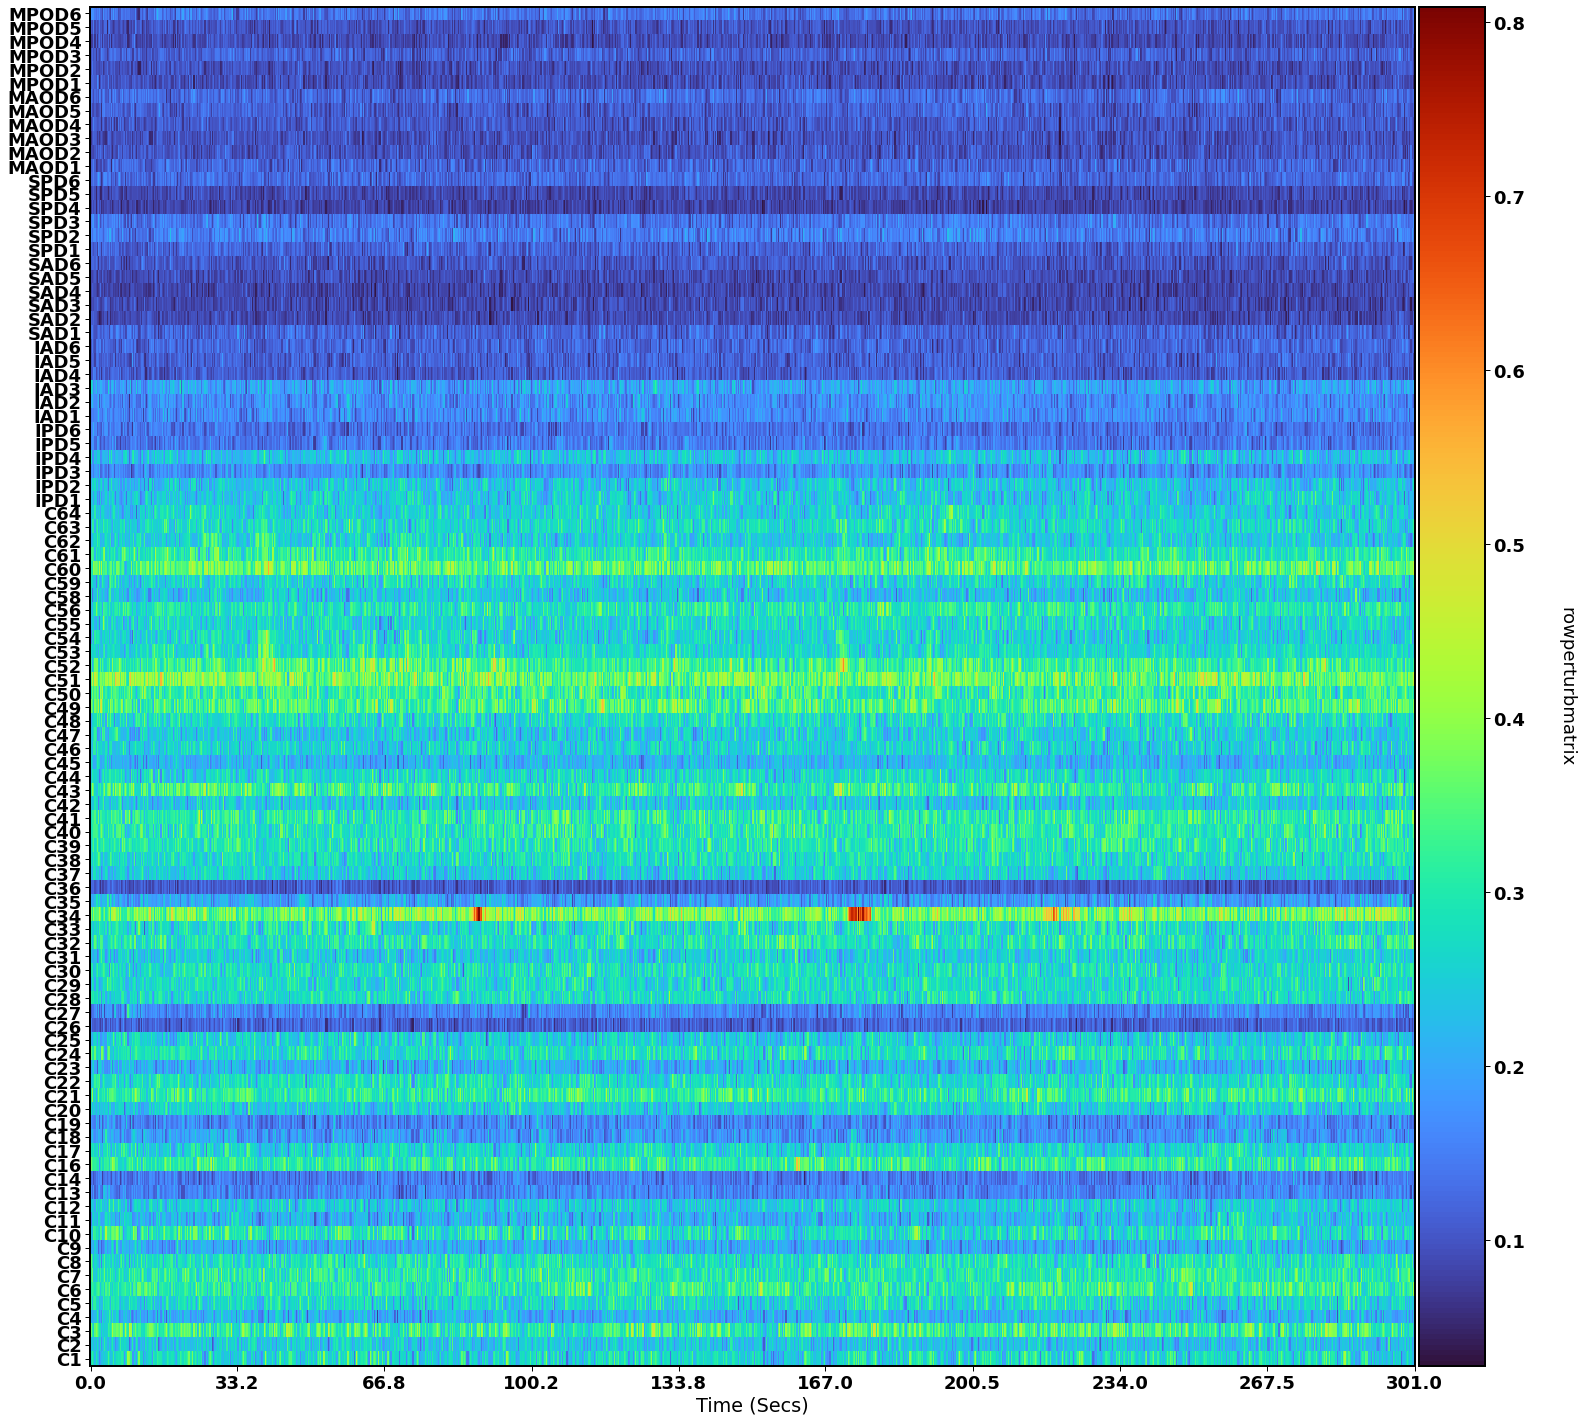

In [264]:
rowderiv.plot_heatmap(cmap='turbo')

<DerivativeNumpy | sub-E1_ses-extraoperative_task-interictalawake_acq-ecog_run-01_desc-perturbmatrix_ieeg.npy, shape: (98, 1205) (98 chs x 1205 times) (301.0 s), ~1.1 MB, data loaded | reference=monopolar | perturbmatrix>


(<Figure size 1800x1800 with 2 Axes>, <AxesSubplot:xlabel='Time (Secs)'>)

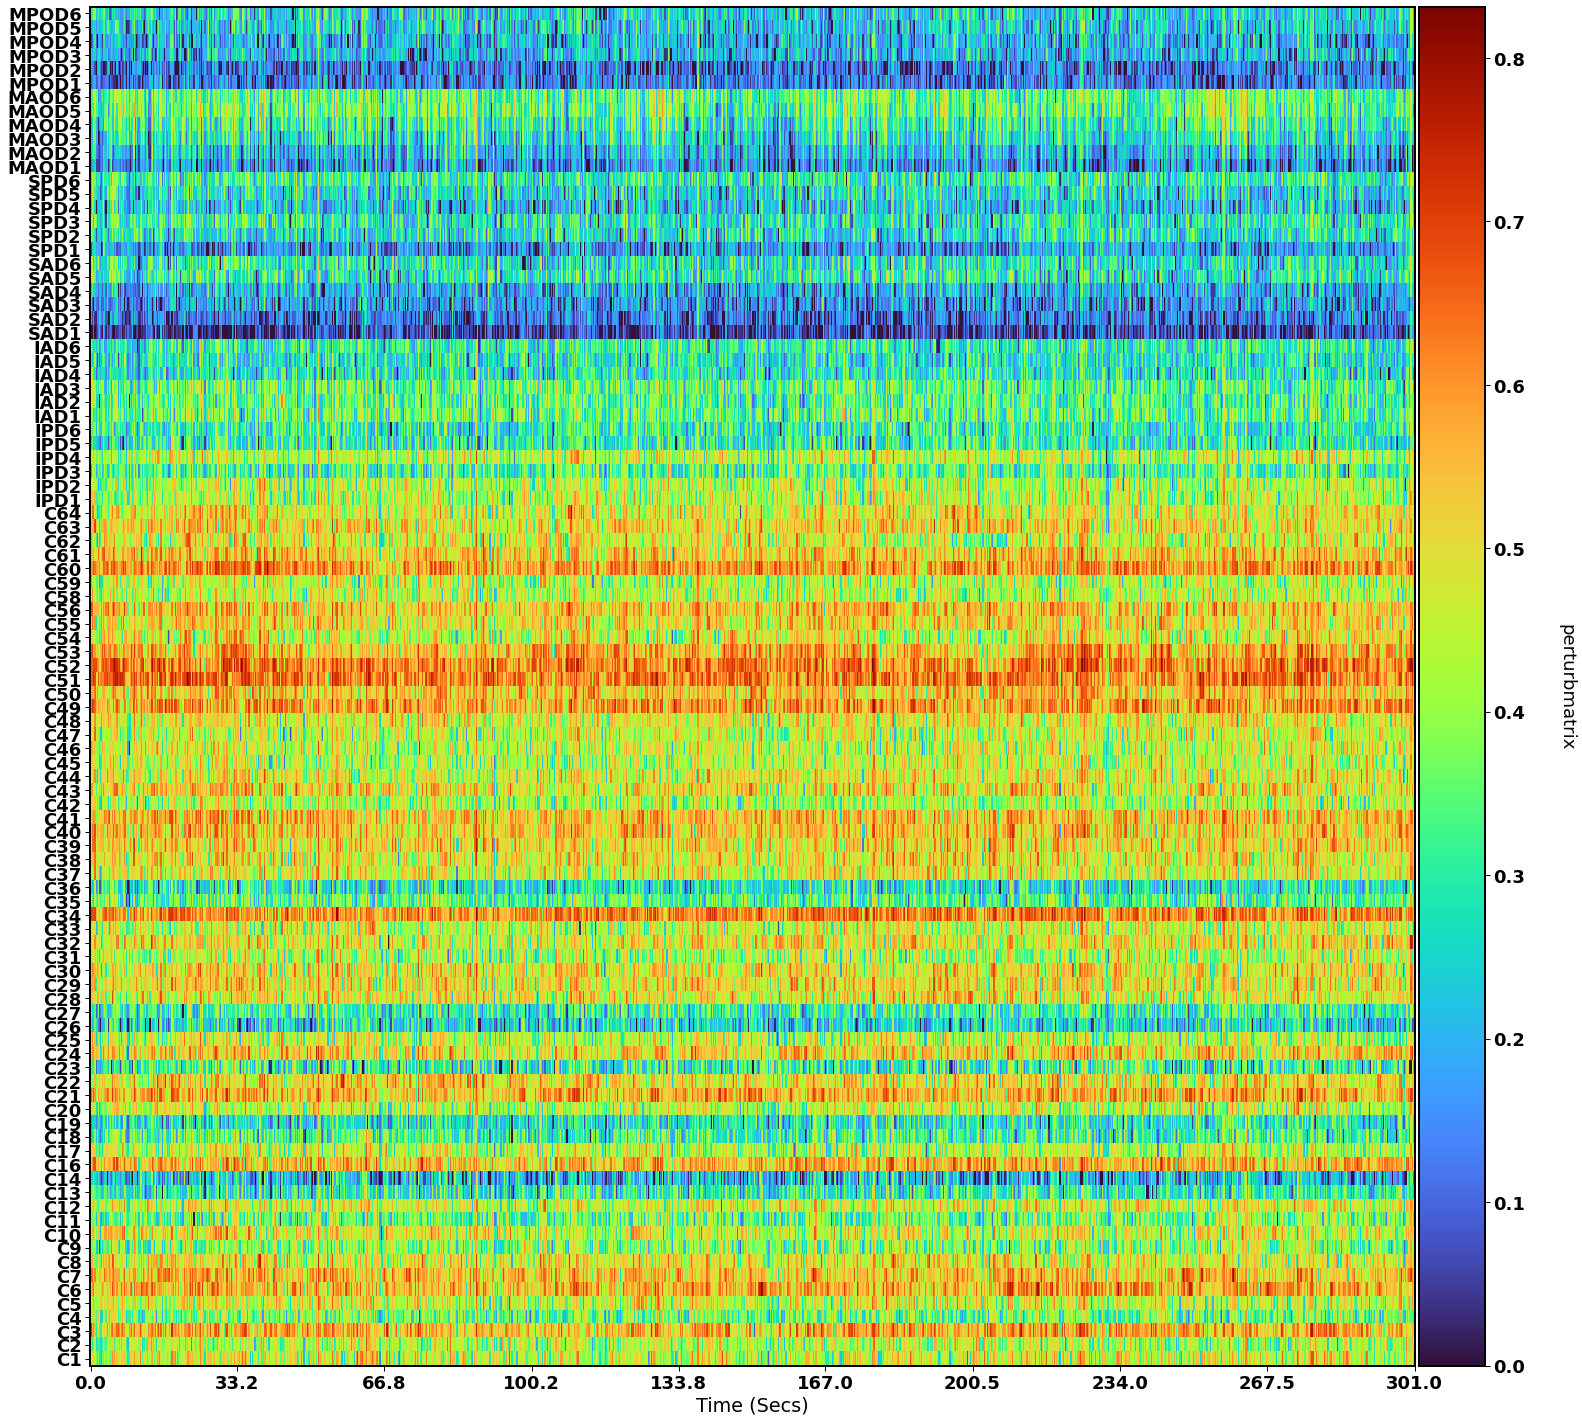

In [265]:
# visualize data
rowderiv_copy = deriv.copy()
rowderiv_copy.normalize()
rowderiv_copy.plot_heatmap(cmap='turbo')

# Analyze Combinations of the Two 

Let's load in both computations and look at the two over time. Specifically, what happens if we compute the element by element ratio?

In [266]:
row_data = rowderiv.get_data()
col_data = deriv.get_data()

[Text(0.5, 1.0, 'Row vs Column Fragility for E1'),
 Text(0.5, 0, 'Row fragility'),
 Text(0, 0.5, 'Col fragility')]

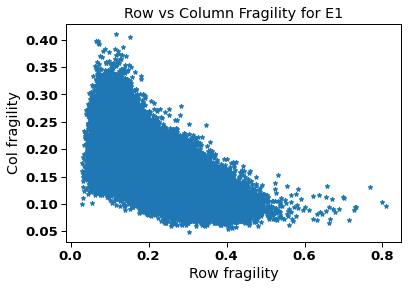

In [267]:
sns.set_context('paper', font_scale=1.5)
fig, ax = plt.subplots()
ax.plot(row_data.flatten(), col_data.flatten(), '*')
ax.set(
    title=f'Row vs Column Fragility for {subject}',
    xlabel='Row fragility',
    ylabel='Col fragility'
)

In [268]:
print(len(rowderiv))
windows_idx = np.arange(len(rowderiv))[::25]
print(len(windows_idx))

1205
49


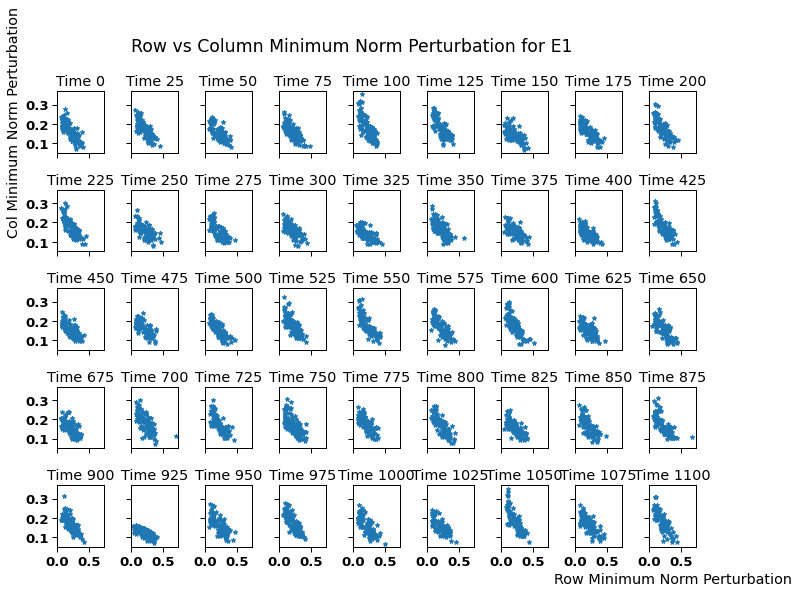

In [269]:
fig, axs = plt.subplots(5, int(len(windows_idx) / 5), 
                        sharex=True, sharey=True, figsize=(10,8))
feature_name = 'Minimum Norm Perturbation'
# does it change over time?
for iwin, ax in zip(windows_idx, axs.flat):
    ax.plot(row_data[:, iwin].flatten(), col_data[:, iwin].flatten(), '*')
    
    ax.set_title(f'Time {iwin}')
    ax.label_outer()
    if iwin == 0:
        ax.set_ylabel(f'Col {feature_name}')
ax.set_xlabel(f'Row {feature_name}')
fig.suptitle(f'Row vs Column {feature_name} for {subject}')
plt.subplots_adjust(hspace = 1)
plt.subplots_adjust(wspace = 0.1)
fig.tight_layout()

In [270]:
rowderiv_copy = rowderiv.copy()
deriv_copy = deriv.copy()
deriv.normalize()
rowderiv_copy.normalize()
row_data = rowderiv_copy.get_data()
col_data = deriv_copy.get_data()

fig, axs = plt.subplots(5, int(len(windows_idx) / 5), 
                        sharex=True, sharey=True, figsize=(10,8))
feature_name = 'Fragility'
# does it change over time?
for iwin, ax in zip(windows_idx, axs.flat):
    ax.plot(row_data[:, iwin].flatten(), col_data[:, iwin].flatten(), '*')
    
    ax.set_title(f'Time {iwin}')
    ax.label_outer()
    if iwin == 0:
        ax.set_ylabel(f'Col {feature_name}')
ax.set_xlabel(f'Row {feature_name}')
fig.suptitle(f'Row vs Column {feature_name} for {subject}')
plt.subplots_adjust(hspace = 1)
plt.subplots_adjust(wspace = 0.1)
fig.tight_layout()

<DerivativeNumpy | sub-E1_ses-extraoperative_task-interictalawake_acq-ecog_run-01_desc-perturbmatrix_ieeg.npy, shape: (98, 1205) (98 chs x 1205 times) (301.0 s), ~1.1 MB, data loaded | reference=monopolar | perturbmatrix>
<DerivativeNumpy | sub-E1_ses-extraoperative_task-interictalawake_acq-ecog_run-01_desc-rowperturbmatrix_ieeg.npy, shape: (98, 1205) (98 chs x 1205 times) (301.0 s), ~1.1 MB, data loaded | reference=monopolar | rowperturbmatrix>
Error in callback <function flush_figures at 0x13128a3a0> (for post_execute):


KeyboardInterrupt: 

## Does it Matter Which Electrodes are Resected

In [271]:
bids_path = BIDSPath(subject=subject, root=root,
                     suffix='channels', extension='.tsv')
ch_fpaths = bids_path.match()

KeyboardInterrupt: 

In [ ]:
# read in sidecar channels.tsv
channels_pd = pd.read_csv(ch_fpaths[0], sep='\t')
description_chs = pd.Series(channels_pd.description.values, index=channels_pd.name).to_dict()
resected_chs = [ch for ch, description in description_chs.items() if description == 'resected']
print(resected_chs)
display(channels_pd)

In [ ]:
resected_inds = [idx for idx, ch in enumerate(deriv.ch_names) if ch in resected_chs]
nrz_inds = [idx for idx in range(len(deriv.ch_names)) if idx not in resected_inds]

In [ ]:
row_data = rowderiv.get_data()
col_data = deriv.get_data()

print(row_data.shape, col_data.shape)

In [ ]:
sns.set_context('paper', font_scale=1.5)
fig, ax = plt.subplots()
ax.plot(row_data[resected_inds, :].flatten(), col_data[resected_inds, :].flatten(), 
        'o', color='red', alpha=0.1, label='resected')
ax.plot(row_data[nrz_inds, :].flatten(), col_data[nrz_inds, :].flatten(), 
        'o', color='blue', alpha=0.1, label='not-resected')
ax.set(
    title=f'Row vs Column Fragility for {subject}',
    xlabel='Row fragility',
    ylabel='Col fragility'
)
ax.legend()
# fig.savefig(figures_path / f'{subject}-all-rowvscol.png')

In [ ]:
print(len(rowderiv))
windows_idx = np.arange(len(rowderiv))[::25]
print(len(windows_idx))

In [ ]:
fig, axs = plt.subplots(5, int(len(windows_idx) / 5), 
                        sharex=True, sharey=True, figsize=(10,8))
feature_name = 'Minimum Norm Perturbation'
# does it change over time?
for iwin, ax in zip(windows_idx, axs.flat):
    ax.plot(row_data[resected_inds, iwin].flatten(), col_data[resected_inds, iwin].flatten(), 
        'o', color='red', alpha=0.4, label='resected')
    ax.plot(row_data[nrz_inds, iwin].flatten(), col_data[nrz_inds, iwin].flatten(), 
            'o', color='blue', alpha=0.4, label='not-resected')
    ax.set_title(f'Time {iwin}')
    ax.label_outer()
    if iwin == 0:
        ax.set_ylabel(f'Col {feature_name}')
ax.set_xlabel(f'Row {feature_name}')
fig.suptitle(f'Row vs Column {feature_name} for {subject}')
plt.subplots_adjust(hspace = 1)
plt.subplots_adjust(wspace = 0.1)
ax.legend(loc=(1.04,0))
fig.tight_layout()
# fig.savefig(figures_path / f'{subject}-overtime-rowvscol-minnorm.png')

In [ ]:
rowderiv_copy = rowderiv.copy()
deriv_copy = deriv.copy()
deriv.normalize()
rowderiv_copy.normalize()
row_data = rowderiv_copy.get_data()
col_data = deriv_copy.get_data()

fig, axs = plt.subplots(5, int(len(windows_idx) / 5), 
                        sharex=True, sharey=True, figsize=(10,8))
feature_name = 'Fragility'
# does it change over time?
for iwin, ax in zip(windows_idx, axs.flat):
    ax.plot(row_data[resected_inds, iwin].flatten(), col_data[resected_inds, iwin].flatten(), 
        'o', color='red', alpha=0.4, label='resected')
    ax.plot(row_data[nrz_inds, iwin].flatten(), col_data[nrz_inds, iwin].flatten(), 
            'o', color='blue', alpha=0.4, label='not-resected')
    
    ax.set_title(f'Time {iwin}')
    ax.label_outer()
    if iwin == 0:
        ax.set_ylabel(f'Col {feature_name}')
ax.set_xlabel(f'Row {feature_name}')
fig.suptitle(f'Row vs Column {feature_name} for {subject}')
plt.subplots_adjust(hspace = 1)
plt.subplots_adjust(wspace = 0.1)
ax.legend(loc=(1.04,0))
fig.tight_layout()
fig.savefig(figures_path / f'{subject}-overtime-rowvscol-fragility.png')

# Looking At the Element-wise Average of All Points

In [ ]:
deriv_copy = deriv.copy()
rowderiv_copy = rowderiv.copy()

deriv_copy.normalize()
rowderiv_copy.normalize()

In [ ]:
deriv_info = deriv.info
# ratio_data = np.divide(deriv_copy.get_data(), rowderiv_copy.get_data(),
#                       out=np.zeros_like(deriv_copy.get_data()), where=rowderiv_copy.get_data()!=0)
ratio_data = np.divide(deriv_copy.get_data() + rowderiv_copy.get_data(), 2)
print(ratio_data.shape)

In [ ]:
ratio_deriv = DerivativeArray(data=ratio_data, info=deriv_info)

In [ ]:
ratio_deriv_copy = ratio_deriv.copy()
# ratio_deriv_copy.normalize()
ratio_deriv_copy.plot_heatmap(
    title=f'{subject}',
    soz_chs=resected_chs
#     cmap='viridis', vmin=-3, vmax=3
)

# Looking at Avg +/- Std Over Time of all Sessions

We grab all runs for each session:
- concatenate them over time,
- mark events there and append to an `Annotations` object. Append `task-<task>-run<run>` event.
- concatenate another session and append now a `ses-event`.

Now, we can visualize this data over time using mne-python. We can visualize at the level of all the sessions, or visualize per task over time.

In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
def load_concat_derivs(deriv_path, subject, session, desc, tasks=None):
    # get all the subject/sessions in the derivative path
    subjects = get_entity_vals(deriv_path, 'subject')
    ignore_subjects = [sub for sub in subjects if sub != subject]
    sessions = get_entity_vals(deriv_path, 'session', ignore_subjects=ignore_subjects)
    ignore_sessions = [ses for ses in sessions if ses != session]

    # store all derivatives found in a list
    derivs = []
    onsets = []
    descriptions = []
    prevlen = 0
    
    if session == 'extraoperative':
        tasks = ['interictal', 'ictal']
        
    if tasks is None:
        # get all the tasks associated if not passed in
        tasks = get_entity_vals(deriv_path, 'task', 
                            ignore_subjects=ignore_subjects,
                            ignore_sessions=ignore_sessions
                           )
    for task in tasks:
        # get all file paths for this subject
        search_str = f'*ses-{session}*task-{task}*desc-{desc}*.json'
        deriv_fpaths = natsorted(list((deriv_path / f'sub-{subject}').glob(search_str)))

#         print(f'Found {len(deriv_fpaths)} derivative file paths')

        for idx, deriv_fpath in enumerate(deriv_fpaths):
            deriv = read_derivative_npy(deriv_fpath, preload=True, 
                                        verbose=False)

            if 'ch_axis' not in deriv.info:
                deriv.info['ch_axis'] = [0]
                rowderiv.info['ch_axis'] = [0 ]

            # create derivative structure
            onsets.append(prevlen + len(deriv))
            descriptions.append(f'ses-{session}-task-{task}-run-{idx+1}')
            prevlen += len(deriv)
    #         if derivative is None:
    #             derivative = deriv.copy()
    #             derivs.append(deriv.copy())
    #         else:
                # check that all channel names are ordered
    #                 if derivative.ch_names != deriv.ch_names:
    #                     deriv.reorder_channels(derivative.ch_names)
    #                     rowderiv.reorder_channels(derivative.ch_names)
    #                 assert derivative.ch_names == deriv.ch_names
    #                 derivative.append(deriv.copy())
            derivs.append(deriv.copy())
    return derivs, onsets, descriptions

In [7]:
def compute_baseline(subject, deriv_root, deriv_chain, task, desc='perturbmatrix'):
    # load interictal snapshots only if available
    deriv_path = Path(deriv_root) / deriv_chain
    deriv_fpath = list(deriv_path.rglob(f'sub-{subject}*_task-{task}*_run-01*_desc-{desc}*.json'))
    if len(deriv_fpath) == 0:
        return None, None
    elif len(deriv_fpath) > 1:
        raise RuntimeError(f'Found more then one file {deriv_fpath}...')
    else:
        deriv_fpath = deriv_fpath[0]
    
    # read in the file
    deriv = read_derivative_npy(deriv_fpath, preload=True)
    deriv.normalize()
    deriv_data = deriv.get_data()
    
    # create mean and std vector
    mean_vec = deriv_data.mean(axis=1)
    std_vec = deriv_data.std(axis=1)
    
    return mean_vec, std_vec

In [8]:
# load in originally ran npy data
root = Path('/Users/adam2392/OneDrive - Johns Hopkins/sickkids/')
# root = Path('/Users/adam2392/Dropbox/epilepsy_bids/')
deriv_root = root / 'derivatives'
reference = 'monopolar'
sampling_res = '1000Hz'  # 'originalsampling'
deriv_chain = Path(sampling_res) / 'radius1.25' / 'fragility' / reference
deriv_path = deriv_root / deriv_chain

figures_path = deriv_root / 'figures'

sessions = ['extraoperative', 'preresection', 
            'intraresection', 'postresection']
desc = 'perturbmatrix'
rowdesc = 'rowperturbmatrix'

In [170]:
subjects = get_entity_vals(deriv_path, 'subject')

subject = 'E7'
ignore_subjects = [sub for sub in subjects if sub != subject]

sessions = get_entity_vals(deriv_path, 'session', ignore_subjects=ignore_subjects)

print(f'Sessions in the deriv path {sessions}')
sessions = ['extraoperative', 'preresection', 'intraresection', 'postresection']
print(sessions)

Sessions in the deriv path ['postresection', 'preresection']
['extraoperative', 'preresection', 'intraresection', 'postresection']


In [171]:
# compute the channel's mean row perturbation values during interictal awake periods
# as a baseline
mean_vec, std_vec = compute_baseline(subject, deriv_root, deriv_chain,
                                     task='interictalawake', desc='rowperturbmatrix')


In [172]:
featurename = 'Col Fragility'
# featurename = 'Row Fragility'
# featurename = 'Absolute Fragility'

# cbarlabel = 'Absolute Diff Fragility'
cbarlabel = 'Col Fragility'
# cbarlabel = 'Row Fragility'

In [173]:
# load all the column perturbation derivatives
derivs = []
onsets = []
descriptions = []

for session in sessions:
    print(session)
    derivs_, onsets_, descrips_ = load_concat_derivs(deriv_path, subject, session, 
                                desc='perturbmatrix')
    derivs.extend(derivs_)
    onsets.extend(onsets_)
    descriptions.extend(descrips_)
print(len(derivs))
print(onsets)

extraoperative
preresection
intraresection
postresection
2
[606, 654]


In [174]:
onsets = []
prevonset = 0
for deriv in derivs:
    onsets.append(len(deriv) + prevonset)
    prevonset += len(deriv)

In [175]:
# load all the row perturbation derivatives
rowderivs = []
for session in sessions:
    print(session)
    derivs_, _, _ = load_concat_derivs(deriv_path, subject, session, 
                                desc='rowperturbmatrix')
    rowderivs.extend(derivs_)
print(len(rowderivs))

extraoperative
preresection
intraresection
postresection
2


In [176]:
bids_path = BIDSPath(subject=subject, root=root,
                     suffix='channels', extension='.tsv')
ch_fpaths = bids_path.match()

print(bids_path)
print(ch_fpaths)
print(deriv.filenames)

/Users/adam2392/OneDrive - Johns Hopkins/sickkids/sub-E7/sub-E7_channels.tsv
[BIDSPath(
root: /Users/adam2392/OneDrive - Johns Hopkins/sickkids
datatype: ieeg
basename: sub-E7_ses-postresection_task-post_acq-ecog_run-01_channels.tsv), BIDSPath(
root: /Users/adam2392/OneDrive - Johns Hopkins/sickkids
datatype: ieeg
basename: sub-E7_ses-preresection_task-pre_acq-ecog_run-01_channels.tsv)]
('/Users/adam2392/OneDrive - Johns Hopkins/sickkids/derivatives/1000Hz/radius1.25/fragility/monopolar/sub-E7/sub-E7_ses-postresection_task-post_acq-ecog_run-01_desc-perturbmatrix_ieeg.npy',)


In [177]:
# read in sidecar channels.tsv
channels_pd = pd.read_csv(ch_fpaths[0], sep='\t')
description_chs = pd.Series(channels_pd.description.values, index=channels_pd.name).to_dict()
resected_chs = [ch for ch, description in description_chs.items() if description == 'resected']
print(resected_chs)
display(channels_pd.head())

['C41', 'C42', 'C49', 'C50', 'C51', 'C57', 'C58', 'C59', 'C60', 'AD1', 'AD2', 'AD3', 'AD4', 'AD5', 'AD6', 'HD3', 'HD4', 'HD5', 'HD6', 'ATPS1', 'ATPS2', 'ATPS3', 'ATPS4', 'ATPS5', 'ATPS6', 'ABTS1', 'ABTS2', 'ABTS3', 'ABTS4', 'ABTS5', 'ABTS6', 'PBTS1', 'PBTS2', 'PBTS3', 'PBTS4', 'PBTS5', 'PBTS6']


,name,type,units,low_cutoff,high_cutoff,description,sampling_frequency,status,status_description,group,reference
0,TRIGGEREVENT,MISC,NaN,0.0,1024.0,Miscellaneous,2048.0,bad,NaN,NaN,NaN
1,C1,ECOG,µV,0.0,1024.0,Electrocorticography,2048.0,good,NaN,grid,C12
2,C2,ECOG,µV,0.0,1024.0,Electrocorticography,2048.0,good,NaN,grid,C12
3,C3,ECOG,µV,0.0,1024.0,Electrocorticography,2048.0,good,NaN,grid,C12
4,C4,ECOG,µV,0.0,1024.0,Electrocorticography,2048.0,good,NaN,grid,C12


In [178]:
resected_inds = [idx for idx, ch in enumerate(deriv.ch_names) if ch in resected_chs]
nrz_inds = [idx for idx in range(len(deriv.ch_names)) if idx not in resected_inds]

In [179]:
derivative = None
new_derivs = []

# loop through each derivative
for deriv, rowderiv in zip(derivs, rowderivs):
    deriv.normalize()
    rowderiv.normalize()
    
    coldata = deriv.get_data()
    rowdata = rowderiv.get_data()
    
    # combine the data if wanted
#     data = np.abs(coldata - rowdata)
    data = coldata.copy()
#     data = rowdata.copy()

    # re-create a new derivative
    new_deriv = DerivativeArray(data, info=deriv.info)
    
    if derivative is None:
        # subtract baseline vector from each time point
#         data = data - mean_vec[:, np.newaxis]
#         new_deriv = DerivativeArray(data, info=deriv.info)
        
        derivative = new_deriv.copy()
    else:
        if not all([ch in deriv.ch_names for ch in derivative.ch_names]):
            # get the set difference of channels
            add_chs = list(set(derivative.ch_names) - set(deriv.ch_names))
            ch_type = derivative.get_channel_types()[0]
            info = create_deriv_info(ch_names=add_chs, sfreq=derivative.info['sfreq'], 
                                     ch_types=ch_type, 
                                     description=derivative.description,
                                    ch_axis=[0])
            addderiv = DerivativeArray(np.ones((len(add_chs), len(deriv)))*-1, info=info, verbose=False)

            # add derivative chs
            new_deriv = new_deriv.add_channels([addderiv])

        if derivative.ch_names != new_deriv.ch_names:
            # add channels and reorder if necessary
            new_deriv.reorder_channels(derivative.ch_names)
            
#             nonrz_inds = [idx for idx, ch in enumerate(new_deriv.ch_names) 
#                          if ch not in add_chs]
#             data = new_deriv.get_data()
#             info = new_deriv.info
#             data[nonrz_inds, :] = data[nonrz_inds, :] - mean_vec[nonrz_inds, np.newaxis]
#             new_deriv = DerivativeArray(data, info=info)
        else:
            # subtract baseline vector from each time point
#             data = data - mean_vec[:, np.newaxis]
            new_deriv = DerivativeArray(data, info=deriv.info)

        derivative.append(new_deriv)                  
    new_derivs.append(new_deriv)
                                
print(derivative)

<DerivativeNumpy | sub-E7_ses-preresection_task-pre_acq-ecog_run-01_desc-perturbmatrix_ieeg.npy, shape: (111, 606) (111 chs x 606 times) (151.2 s), ~728 kB, data loaded | reference=monopolar | perturbmatrix>
<DerivativeNumpy | sub-E7_ses-preresection_task-pre_acq-ecog_run-01_desc-rowperturbmatrix_ieeg.npy, shape: (111, 606) (111 chs x 606 times) (151.2 s), ~728 kB, data loaded | reference=monopolar | rowperturbmatrix>
<DerivativeNumpy | sub-E7_ses-postresection_task-post_acq-ecog_run-01_desc-perturbmatrix_ieeg.npy, shape: (70, 654) (70 chs x 654 times) (163.2 s), ~488 kB, data loaded | reference=monopolar | perturbmatrix>
<DerivativeNumpy | sub-E7_ses-postresection_task-post_acq-ecog_run-01_desc-rowperturbmatrix_ieeg.npy, shape: (70, 654) (70 chs x 654 times) (163.2 s), ~488 kB, data loaded | reference=monopolar | rowperturbmatrix>
<DerivativeArray | None, shape: (41, 654) (41 chs x 654 times) (163.2 s), ~290 kB, data loaded | reference=None | perturbmatrix>
<DerivativeArray | None, sh

['ses-preresection-task-pre-run-1', 'ses-postresection-task-post-run-1']


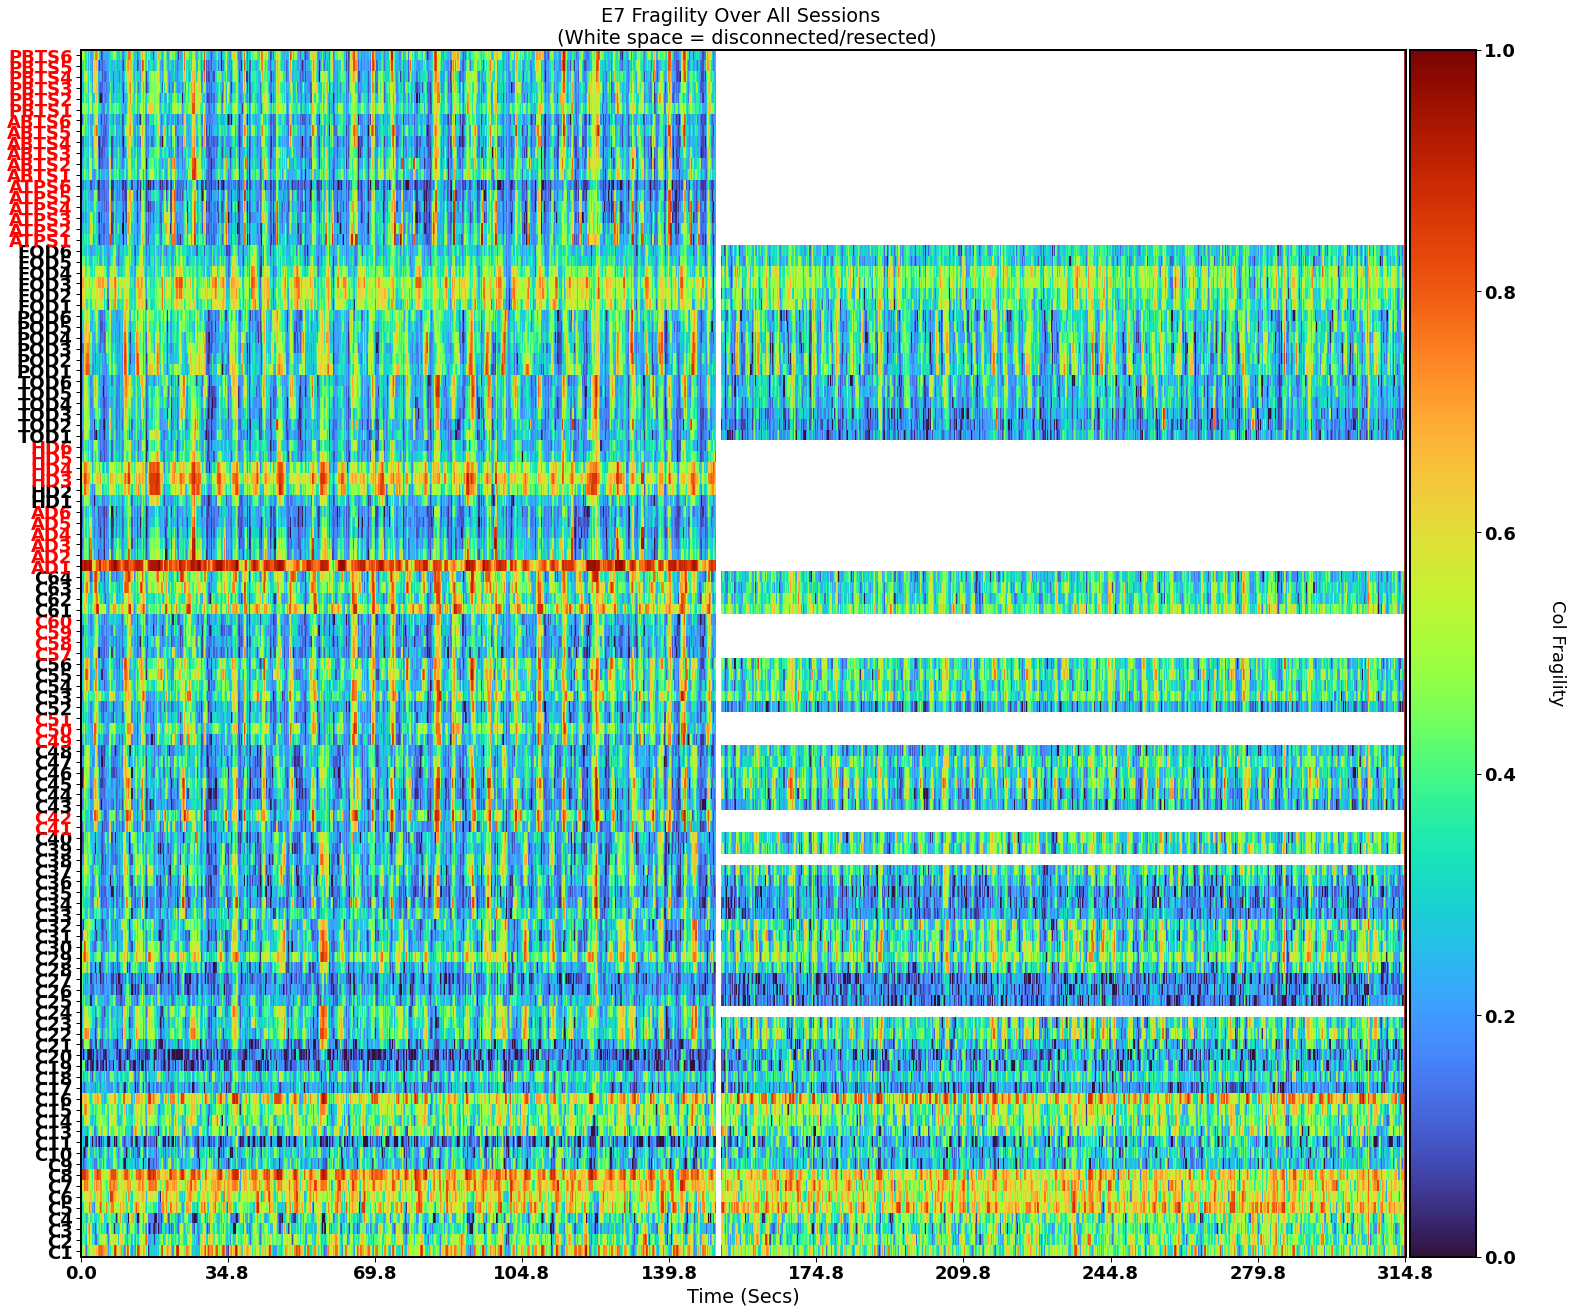

In [180]:

title = f'{subject} Fragility Over All Sessions \n (White space = disconnected/resected)'
fig, ax = derivative.plot_heatmap(
    vmin=0, vmax=1, title=title, 
    soz_chs=resected_chs, cbarlabel=cbarlabel,
)
sns.set_context('paper', font_scale=2.0)

colors = {'extraoperative': 'black',
          'preresection': 'white',
          'intraresection': 'gray',
          'postresection': 'brown'}

for onset, description in zip(onsets, descriptions):
    session = description.split('-')[1]
    color = colors[session]
    ax.axvline(onset, label=description, lw=5, color=color)

pprint(descriptions)
# ax.legend(loc=(1.04, 0))
# fig.savefig(figures_path / f'{subject}_{reference}_{cbarlabel}_allsessions_baseline-rowiiaw.png', 
#            bbox_inches='tight')

# Compute multivariate difference between the two periods

In [104]:
# keep track of the dataframe summary
df_summ = []
df = pd.DataFrame()

Empty DataFrame
Columns: []
Index: []


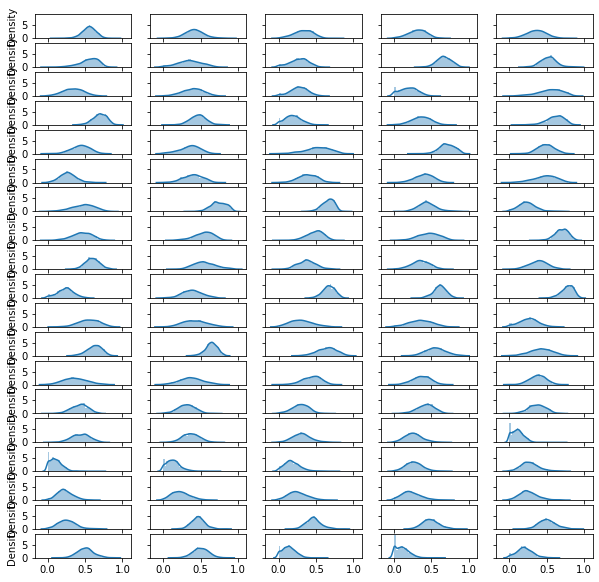

In [31]:
fig, axs = plt.subplots(len(pre_deriv.ch_names) // 5, 5, figsize=(10, 10), 
                       sharex=True, sharey=True)

for i, ax in enumerate(axs.flat):
    sns.distplot(test.get_data()[i, :], ax=ax)

In [181]:
pre_deriv = [deriv for deriv in derivs if 'task-pre' in deriv.filenames[0]][0]
post_deriv = [deriv for deriv in derivs if 'task-post' in deriv.filenames[0]][0]

pre_data = pre_deriv.get_data()
post_data = post_deriv.get_data()
print(pre_data.shape, post_data.shape)

(111, 606) (70, 654)


In [182]:
print(preb.shape, postb.shape)

(626,) (239,)


In [183]:
# set threshold
threshold = 0.25

# compute effect size difference with sub-sampling
pre_blocks = pre_deriv.subsample_blocks()
post_blocks = post_deriv.subsample_blocks()

cohensd = []

stats = []
pvals = []

for preb, postb in zip(pre_blocks, post_blocks):
    if threshold is not None:
        preb[preb < threshold] = np.nan
        postb[postb < threshold] = np.nan
        
    # drop any nans
    preb = preb[~np.isnan(preb)]
    postb = postb[~np.isnan(postb)]
    
    stat, pvalue = KSample("Dcorr").test(preb, postb)
    stats.append(stat)
    pvals.append(pvalue)
    
    es = pg.compute_effsize(preb, postb, 
                            paired=False, eftype='cohen')
    
    cohensd.append(es)
    
    df_summ.append([subject, es, stat, pvalue])

In [184]:
subj_df = pd.DataFrame(df_summ, columns=['subject', 'es', 'stat', 'pval'])
print(df.shape)
if df.empty:
    df = subj_df
else:
    df = pd.concat((df, subj_df), axis=0)

display(subj_df.head())
print(df.shape, subj_df.shape)

(1900, 4)


,subject,es,stat,pval
0,E3,0.822098,0.114334,0.000008
1,E3,0.572214,0.066987,0.000068
2,E3,0.261652,0.009229,0.135580
3,E3,0.465223,0.038631,0.007058
4,E3,0.560348,0.061168,0.000130


(2600, 4) (700, 4)


0.032 +/- 0.096


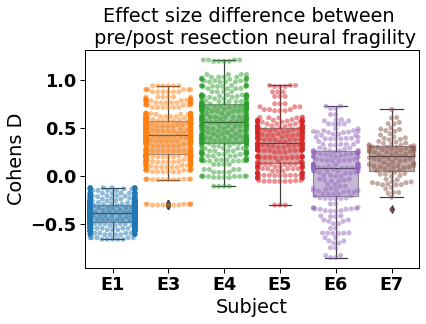

In [190]:
fig, ax = plt.subplots()
sns.swarmplot(x='subject', y='es',
              order=natsorted(df['subject'].unique()),
              alpha=0.5,
              data=df, ax=ax)
sns.boxplot(x='subject', y='es', 
            order=natsorted(df['subject'].unique()), 
            data=df, ax=ax, boxprops=dict(alpha=0.5))

ax.set(
    xlabel='Subject',
    ylabel='Cohens D',
    title='Effect size difference between \n pre/post resection neural fragility'
)

print(f'{np.mean(pvals):.3f} +/- {np.std(pvals):.3f}')

[None,
 Text(0.5, 0, 'Subject'),
 Text(0, 0.5, 'Pvalue'),
 Text(0.5, 1.0, 'Nonparametric MANOVA pvalue between \n pre/post resection neural fragility')]

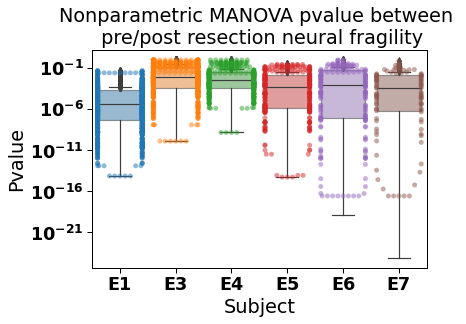

In [192]:
fig, ax = plt.subplots()
sns.swarmplot(x='subject', y='pval',
              order=natsorted(df['subject'].unique()),
              alpha=0.5,
              data=df, ax=ax)
sns.boxplot(x='subject', y='pval', 
            order=natsorted(df['subject'].unique()), 
            data=df, ax=ax, boxprops=dict(alpha=0.5))

ax.set(
    yscale='log',
    xlabel='Subject',
    ylabel='Pvalue',
    title='Nonparametric MANOVA pvalue between \n pre/post resection neural fragility'
)

0.009 +/- 0.034


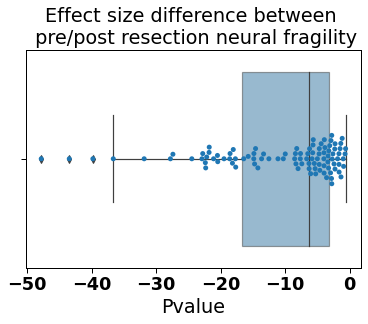

In [99]:
fig, ax = plt.subplots()
sns.swarmplot(np.log10(pvals), ax=ax)
sns.boxplot(np.log10(pvals), ax=ax, boxprops=dict(alpha=0.5))

ax.set(
    xlabel='Pvalue',
    title='Effect size difference between \n pre/post resection neural fragility'
)

print(f'{np.mean(pvals):.3f} +/- {np.std(pvals):.3f}')

0.354 +/- 0.294


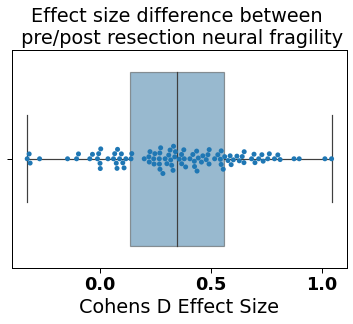

In [93]:
fig, ax = plt.subplots()
sns.swarmplot(cohensd, ax=ax)
sns.boxplot(cohensd, ax=ax, boxprops=dict(alpha=0.5))

ax.set(
    xlabel='Cohens D Effect Size',
    title='Effect size difference between \n pre/post resection neural fragility'
)

print(f'{np.mean(cohensd):.3f} +/- {np.std(cohensd):.3f}')

In [94]:
from hyppo.independence import MGC
from hyppo.ksample import KSample

In [32]:
# test statistic and p-values can be calculated for MGC, but a little slow ...
stat, pvalue = KSample("Dcorr").test(pre_data, post_data)

print("Energy test statistic:", stat)
print("Energy p-value:", pvalue)

ValueError: Shape mismatch, inputs must have shape [n, p] and [m, p].

In [28]:
mgc = MGC(compute_distance=None)
stat, pvalue, _ = mgc.test(pre_data, post_data)

ValueError: Shape mismatch, x and y must have shape [n, p] and [n, q].

In [48]:
# sns.set_context('paper', font_scale=1.3)
# featurename = 'Col Fragility'
# fig, ax = plt.subplots()
# for idx in range(len(qranges)):
#     y = toplot_data[idx, :]
#     ax.plot(y, label=f'qtile-{qranges[idx]}')

# ylim = ax.get_ylim()
    
# start = 0
# for stop, label in zip(onsets, descriptions):
#     # fill between
#     ax.fill_betweenx(ylim, start, stop, label=label)
#     start = stop
# ax.legend(descriptions, loc=(1.04, 0), ncol=2)
# ax.set(
#     title=f'{subject} - {featurename} Quantiles Over All Sessions',
#     xlabel='Time (A.U.)',
#     ylabel='Normalized Fragility'
# )
# fig.savefig(figures_path / f'{subject}-{featurename}-meanwithinqtiles-overallsessions.png')

# Computing the Effect Size Difference Across Sessions

In [312]:
toplot_data = []

# create plot over the onsets
for deriv, description, onset in zip(derivs, descriptions, onsets):
    # get the data
    deriv_data = deriv.get_data()
    ch_names = np.array(deriv.ch_names)
    
    # apply mask
    mask = deriv_data[:, 0] != -1
    deriv_data = deriv_data[mask, :]
    ch_names = ch_names[mask]
    
    # get quantiles
    qranges = np.linspace(0.1, 1.0, 20)
    data_quantiles = np.quantile(deriv_data, axis=0, q=qranges)
    print(data_quantiles.shape)
    
    # compute mean within quantiles
    qtile_means = compute_mean_within_quantiles(deriv_data, data_quantiles)
    
    toplot_data.append(qtile_means)
toplot_data = np.hstack(toplot_data)

(20, 606)


NameError: name 'compute_mean_within_quantiles' is not defined

In [ ]:
session_dict = collections.defaultdict(list)
session_names = []
data = []

prevonset = 0
for onset, description in zip(onsets, descriptions):
    key = description
#     if 'ses-extraoperative' in description:
#         key = description
#     elif 'ses-preresection' in description:
#         key = 'ses-preresection'
#     elif 'ses-postresection' in description:
#         key = 'ses-postresection'
#     elif 'ses-intraresection' in description:
#         key = 'ses-intraresection'
#     else:
#         print('continuing... ')
#         continue
#     print(prevonset, onset)
#     session_dict[key] = toplot_data[-1, prevonset:onset]
    _data = toplot_data[-1, prevonset:onset]
    session_names.extend([key] * len(_data))
    data.extend(_data)
    
    prevonset = onset

print(len(np.unique(session_names)))

In [ ]:
print(len(session_names), len(data))
print(len(onsets), len(descriptions))
print(np.unique(session_names))

In [ ]:
print(np.unique(session_names))
ordered_ses_names = {ses: 1 for ses in session_names}.keys()
print(ordered_ses_names)

In [ ]:
session_df = pd.DataFrame((session_names, data)).T
session_df.columns=['session', 'qtile']
session_df['qtile'] = pd.to_numeric(session_df['qtile'])

#1: Prepare auxilary column 'id_num': 
df = session_df.copy()
# df.reset_index(inplace=True)
# df['id_num'] = df[['session', 'qtile']].apply(tuple, axis=1)
# df = df.drop(columns=['session', 'qtile'])

#2: 'pivot' is almost an inverse of melt:
# df = df.pivot(index='index', columns='session', values='qtile')

display(df.head())
print(df.shape, session_df.shape)
# display(session_df.head())

In [ ]:
fig, ax = plt.subplots()
ax = sns.boxplot(data=df, x='session', y='qtile', order=ordered_ses_names, ax=ax, 
                 palette=['blue', 'purple', 'green', 'orange', 'red'],
                 boxprops=dict(alpha=0.75)
                )
ax = sns.swarmplot(data=df.sample(frac=0.15), x='session', y='qtile', color='black',
                   order=ordered_ses_names, ax=ax, alpha=0.5)
ax.set_xticklabels(
#     ax.get_xticklabels(),
    np.arange(len(ordered_ses_names)), 
                   rotation=45, ha='right')
ax.set(
    ylabel='Mean (95-100th) quantile',
    title=f'{subject} {featurename} Quantile\n Distributions Over Sessions'
)
# create blank rectangles
legend_actors = []
for idx in range(len(ordered_ses_names)):
    extra = mpl.patches.Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)
    legend_actors.append(extra)
ax.legend(legend_actors, list([f'{idx}={ses}' for idx, ses in enumerate(ordered_ses_names)]), 
         loc=(1.04, 0))
fig.savefig(figures_path / f'{subject}-{featurename}-{reference}-boxplot-overallsessions.png',
           bbox_inches='tight')

In [ ]:
shorthand_ses = {ses: f'{idx}' for idx, ses in enumerate(ordered_ses_names)}

In [ ]:
df['session'] = df['session'].replace(shorthand_ses)

In [ ]:
dabest_ses = dabest.load(df.sample(frac=0.5), x='session', y='qtile',
#                          idx=np.unique(session_names),
                        idx=np.arange(len(shorthand_ses)).astype(str),
                         resamples=500,
                   )


In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
fig = dabest_ses.cohens_d.plot(ax=ax, 
#                                color_col='session',
#                                custom_palette=['blue', 'orange', 'green', 'red', 'purple']
                              )
ax.set(
    title=f'{subject} Session Comparison \n{reference} {featurename}'
)
print('Done')
print(fig)
fig.tight_layout()
fig.savefig(
    figures_path / f'{subject}-{featurename}-{reference}-cohensd-overallsessions.png',
    bbox_inches='tight'
)